# Анализ поездок в такси. 

## Часть 3: Предсказание Tips.

Построим регрессионную модель машинного обучения для предсказания размера чаевых за поездку.

In [84]:
import pandas as pd
import numpy as np

df_filename = './data/Taxi_Trips_Clean.zip'

In [85]:
df = pd.read_csv(df_filename, compression='zip')

In [86]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [87]:
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])
df['Trip End Timestamp'] = pd.to_datetime(df['Trip End Timestamp'])

In [88]:
def extract_time_features(df: pd.DataFrame):
    df = df.copy()
    df['Trip Start Month'] = df['Trip Start Timestamp'].dt.month
    df['Trip Start Day'] = df['Trip Start Timestamp'].dt.day_of_year
    df['Trip Start Day Of Week'] = df['Trip Start Timestamp'].dt.day_of_week
    df['Trip Start Hour'] = df['Trip Start Timestamp'].dt.hour
    df['Trip Start Hour Sin'] = pd.Series(
        np.sin(df['Trip Start Hour'] * 2 * np.pi / 12 - np.pi / 2))
    df = df.drop(columns=['Trip Start Timestamp'])
    return df

def calc_errors(y_true, y_pred, console_output: bool = True):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    if console_output:
        print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}.')

    return mae, mse, rmse

Пока что не будем использовать информацию об авто Taxi ID. Так мы не можем использовать следующие данные "из будущего":
- Trip End Timestamp
- Trip Seconds
- Tolls
- Extras,
- Trip Total

Считаем, что водитель знает куда и по какому маршруту ему нужно двигаться и сколько будет стоить составлять базовая стоимость поездки. А также считаем, что водитель с пассажиром заранее договариваются, каким способом будет осуществляться оплата.

### 1. Случайный лес

Обучать будем на самых значимых признаках: координатах, милях пути, базовой стоимости Fare и сгенерированном синусе времени суток. Также добавим в рассмотрение категориальные признаки.

In [89]:
datetime_features = ['Trip Start Timestamp']
numerical_features = ['Trip Miles', 'Fare', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
                      'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']
categorical_features = ['Payment Type', 'Company']
target = 'Tips'

In [90]:
features = datetime_features + numerical_features + categorical_features

X = df[features]
y = df[target]

X.head()

,Trip Start Timestamp,Trip Miles,Fare,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Payment Type,Company
0,2024-03-01,3.00,12.00,41.901207,-87.676356,41.899602,-87.633308,Cash,Taxi Affiliation Services
1,2024-03-01,6.13,18.51,41.899602,-87.633308,41.965812,-87.655879,Mobile,5 Star Taxi
2,2024-03-01,11.17,29.75,41.874005,-87.663518,41.874005,-87.663518,Prcard,5 Star Taxi
3,2024-03-01,9.90,26.75,41.874005,-87.663518,41.944227,-87.655998,Cash,Taxi Affiliation Services
4,2024-03-01,2.49,10.50,41.899602,-87.633308,41.899602,-87.633308,Prcard,City Service


In [91]:
y.head()

0    0.00
1    4.31
2    0.07
3    0.00
4    0.00
Name: Tips, dtype: float64

In [92]:
datetime_transformer = FunctionTransformer(
    extract_time_features, validate=False)

categorical_transformer = ColumnTransformer(
    transformers=[
        ('payment_type', OneHotEncoder(sparse_output=False), ['Payment Type']),
        ('company', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['Company'])
    ], remainder='passthrough')

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [93]:
preprocessor = ColumnTransformer(
    transformers=[
        ('datetime', datetime_transformer, datetime_features),
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features)
    ])


In [94]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=37))
])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=37)

In [96]:
%%time
model_rf.fit(X_train, y_train)

CPU times: user 4min 43s, sys: 507 ms, total: 4min 44s
Wall time: 4min 45s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7f12697fa3e0>),
                                                  ['Trip Start Timestamp']),
                                                 ('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('payment_type',
                                                                                   OneHotEncoder(sparse_output=False),
                                                                                   ['Payment '
                                                                                    'Type']),
                                                                                  ('company',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Company'])]),
                                                  ['Payment Type', 'Company']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Trip Miles', 'Fare',
                                                   'Pickup Centroid Latitude',
                                                   'Pickup Centroid Longitude',
                                                   'Dropoff Centroid Latitude',
                                                   'Dropoff Centroid '
                                                   'Longitude'])])),
                ('regressor', RandomForestRegressor(random_state=37))])

In [97]:
y_pred = model_rf.predict(X_test)

In [98]:
calc_errors(y_test, y_pred);

MAE: 0.47318576925031575, MSE: 0.951811639953191, RMSE: 0.9756083435237682.


Попробуем изменить скейлер на RobustScaler, так как Standart Scaler может плохо работать для основных признаков (по уровню корреляции) в силу того, что центр города, а значит, и центр распределения поездок лежит рядом с береговой линией, которая обрезает это распределение.

In [99]:
from sklearn.preprocessing import RobustScaler

model_rf.set_params(preprocessor__numerical=RobustScaler())


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7f12697fa3e0>),
                                                  ['Trip Start Timestamp']),
                                                 ('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('payment_type',
                                                                                   OneHotEncoder(sparse_output=False),
                                                                                   ['Payment '
                                                                                    'Type']),
                                                                                  ('company',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Company'])]),
                                                  ['Payment Type', 'Company']),
                                                 ('numerical', RobustScaler(),
                                                  ['Trip Miles', 'Fare',
                                                   'Pickup Centroid Latitude',
                                                   'Pickup Centroid Longitude',
                                                   'Dropoff Centroid Latitude',
                                                   'Dropoff Centroid '
                                                   'Longitude'])])),
                ('regressor', RandomForestRegressor(random_state=37))])

In [100]:
%%time
model_rf.fit(X_train, y_train)

CPU times: user 4min 31s, sys: 575 ms, total: 4min 32s
Wall time: 4min 33s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7f12697fa3e0>),
                                                  ['Trip Start Timestamp']),
                                                 ('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('payment_type',
                                                                                   OneHotEncoder(sparse_output=False),
                                                                                   ['Payment '
                                                                                    'Type']),
                                                                                  ('company',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Company'])]),
                                                  ['Payment Type', 'Company']),
                                                 ('numerical', RobustScaler(),
                                                  ['Trip Miles', 'Fare',
                                                   'Pickup Centroid Latitude',
                                                   'Pickup Centroid Longitude',
                                                   'Dropoff Centroid Latitude',
                                                   'Dropoff Centroid '
                                                   'Longitude'])])),
                ('regressor', RandomForestRegressor(random_state=37))])

In [101]:
y_pred = model_rf.predict(X_test)

In [102]:
calc_errors(y_test, y_pred);

MAE: 0.4731263177137697, MSE: 0.9518200272344199, RMSE: 0.9756126420021524.


Существенных изменений нет. Попробуем другую модель -- XGBoost.

### 2. Градиентный бустинг

In [103]:
from xgboost import XGBRFRegressor

In [104]:
model_xgb = model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRFRegressor(random_state=37))
])

In [105]:
%%time
model_xgb.fit(X_train, y_train)

CPU times: user 20.9 s, sys: 116 ms, total: 21 s
Wall time: 3.27 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7f12697fa3e0>),
                                                  ['Trip Start Timestamp']),
                                                 ('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('payment_type',
                                                                                   OneHotEncoder(sparse_output=False),
                                                                                   ['Payment '
                                                                                    'Type']),
                                                                                  ('company',
                                                                                   OneHotEncoder(handle_unk...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                multi_strategy=None, n_estimators=None,
                                n_jobs=None, num_parallel_tree=None,
                                objective='reg:squarederror', random_state=37,
                                reg_alpha=None, ...))])

In [106]:
y_pred = model_xgb.predict(X_test)

In [107]:
calc_errors(y_test, y_pred);

MAE: 0.46795099775180693, MSE: 0.9448651631617573, RMSE: 0.9720417497009876.


Попробуем обучить на других моделях.

### 3. Линейная регрессия

In [108]:
from sklearn.linear_model import LinearRegression

In [109]:
model_lr = model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [110]:
%%time
model_lr.fit(X_train, y_train)

CPU times: user 7.24 s, sys: 124 ms, total: 7.37 s
Wall time: 1.95 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7f12697fa3e0>),
                                                  ['Trip Start Timestamp']),
                                                 ('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('payment_type',
                                                                                   OneHotEncoder(sparse_output=False),
                                                                                   ['Payment '
                                                                                    'Type']),
                                                                                  ('company',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Company'])]),
                                                  ['Payment Type', 'Company']),
                                                 ('numerical', RobustScaler(),
                                                  ['Trip Miles', 'Fare',
                                                   'Pickup Centroid Latitude',
                                                   'Pickup Centroid Longitude',
                                                   'Dropoff Centroid Latitude',
                                                   'Dropoff Centroid '
                                                   'Longitude'])])),
                ('regressor', LinearRegression())])

In [111]:
y_pred = model_lr.predict(X_test)

In [112]:
calc_errors(y_test, y_pred);

MAE: 0.7148374456841069, MSE: 1.2956100438289515, RMSE: 1.1382486739851496.


Модель линейной регрессии показала себя плохо в сравнении с предыдущими моделями. Этого стоило ожидать, учитывая, что в данных содержится мало фич с достаточно сильной корреляцией с целевым признаком.

### 4. Градиентный бустинг. Тюнинг гиперпараметров.

В сыром виде XGBoost показывает несравнимо большую эффективность по времени обучения в сравнении со случайным лесом из sklearn и обходит по точности модель линейной регрессии. Остановимся на этом алгоритме и попробуем подогнать гиперпараметры. Возможно, получится применить кросс-валидацию.

In [113]:
from sklearn.model_selection import cross_val_score
from scipy.stats import randint, uniform
from hyperopt import hp, Trials, STATUS_OK, fmin

In [114]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 10),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}

def objective(params):
    model = XGBRFRegressor(n_estimators=int(params['n_estimators']),
                           max_depth=int(params['max_depth']),
                           learning_rate=params['learning_rate'],
                           subsample=params['subsample'],
                           objective='reg:squarederror',
                           )
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    score = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return {'loss': score, 'status': STATUS_OK}



In [115]:
%%time

trials = Trials()

best = fmin(fn=objective,
            space=space,
            max_evals=50,
            trials=trials,)

TPE is being used as the default algorithm.


  6%|▌         | 3/50 [02:38<49:36, 63.33s/trial, best loss: 9.336017520886042]

/home/anatolii/Soft/miniforge3/envs/taxi-trips-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



100%|██████████| 50/50 [32:31<00:00, 39.03s/trial, best loss: 0.9116138199001448]
CPU times: user 17.1 s, sys: 6.43 s, total: 23.5 s
Wall time: 32min 31s


Данных достаточно много, поэтому кросс-валидацию настроим на разбиение на 3 подмножества.

In [117]:
best_model = XGBRFRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            learning_rate=best['learning_rate'],
                            subsample=best['subsample'],
                            objective='reg:squarederror')

best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

In [118]:
%%time
best_pipeline.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 578 ms, total: 1min 17s
Wall time: 11.3 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7f12697fa3e0>),
                                                  ['Trip Start Timestamp']),
                                                 ('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('payment_type',
                                                                                   OneHotEncoder(sparse_output=False),
                                                                                   ['Payment '
                                                                                    'Type']),
                                                                                  ('company',
                                                                                   OneHotEncoder(handle_unk...
                                interaction_constraints=None,
                                learning_rate=np.float64(1.0323184663812155),
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=15, max_leaves=None,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, multi_strategy=None,
                                n_estimators=100, n_jobs=None,
                                num_parallel_tree=None,
                                objective='reg:squarederror', random_state=None, ...))])

In [119]:
y_pred = best_pipeline.predict(X_test)

In [120]:
calc_errors(y_test, y_pred);

MAE: 0.46251168120811914, MSE: 0.9289705431875218, RMSE: 0.9638311798170476.


Байесовский оптимизатор немного улучшил результаты градиентного бустинга. В итоге получилась модель, которая ошибается в среднем на $0.46.

Построим график этой ошибки для тестовой выборки.

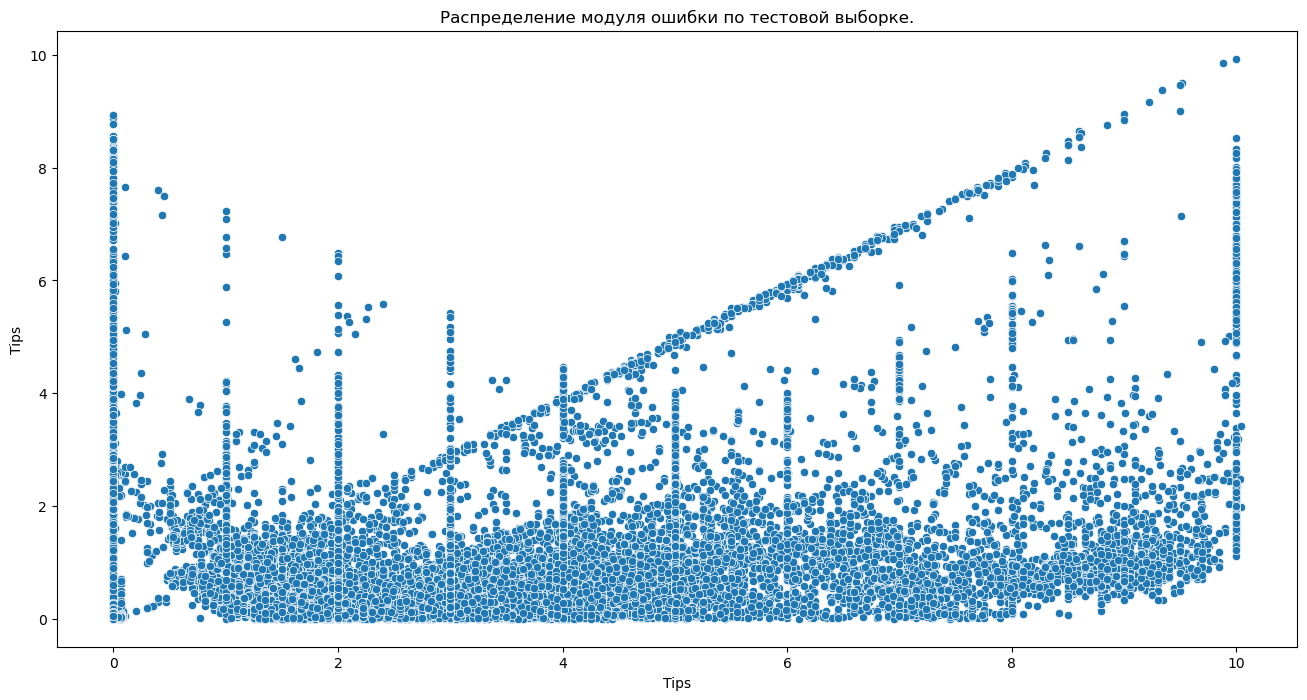

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(16, 8))

sns.scatterplot(x=y_test, y=np.abs(y_test - y_pred))

plt.title('Распределение модуля ошибки по тестовой выборке.')

plt.show()

Видно, что модель плохо предсказывает целые значения чаевых. Объяснение этого, скорее всего, заключается в том, что такие чаевые являются выбросами в том смысле, что они сильно зависят от пассажира. Чаевые, которые не являются целыми числами (скорее всего большая их часть оплачивается автоматически через приложения-посредники) предсказываются намного лучше. Также видно влияние преобладания поездок без чаевых -- промахи, когда модель предсказывает отсутствие чаевых или близкое к нулю значения выстраиваются в кластер точек, лежащих близко к прямой y_pred=y_test.